In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

def psy_analytic(x, lamb = 1, case = 1):
    '''
        psy_analytic = np.exp(lamb*x)
    '''
    if case == 1:
        return tf.exp(lamb*x)
    elif case == 2:
        return tf.sin(x)
    elif case == 3:
        return -1 / (1 + x)

def A(x, case = 1):
    if case == 1:
        return -1

def B(x, case = 1):
    if case == 1:
        return 0

def f(x, psy, case = 1):
    if case == 1:
        '''
            d(psy)/dx = f(x, psy)
            y' = B(x) - A(x) * y
        '''
        return B(x) - A(x)*psy
    
    elif case == 2:
        '''
            Prothero Robinson
            y' 
        '''
        return -(psy - tf.sin(x)) + tf.cos(x)

    elif case == 3:
        return psy**2

def y(x, w, case = 1): 
    '''
        y(x) = bias + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    if case == 1:
        bias = 1.
    elif case == 2:
        bias = 0.
    elif case == 3:
        bias = -1.

    y = bias
    w_v = w.variables[0]
    n = w_v.shape[0]
    for i in range(1, n+1):
        y += w_v[i-1]*x**i
    
    return y

def y_loss(x, w, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    
    # x_0 = tf.zeros((1, 1))
    # one = tf.ones((1, 1))
    
    with tf.GradientTape() as tape:
        tape.watch(x)

        _y = y(x, w, case = case)
        d_y = tape.gradient(_y, x)
    
    _loss = d_y - f(x, _y, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def y_EC_loss(x, w, NN, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    x_0 = tf.zeros((1, 1))
    one = tf.ones((1, 1))
    w_v = w.variables[0]
    n = w_v.shape[0]

    with tf.GradientTape() as tape:
        tape.watch(x)

        y_EC = tf.add(y(x, w, case), NN(x)*x)
        d_y_EC = tape.gradient(y_EC, x)

    _loss = d_y_EC - f(x, y_EC, case)
    init_loss = NN(x_0) - one
    square_loss = tf.square(_loss) + tf.square(init_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def train(train_x, n, case):
    NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(n, ), dtype=tf.float32))

    print('start y')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))

    print('start y + EC')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_EC_loss(train_x, w, NN, case)

            grad_NN = tape.gradient(train_loss, NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))
    
    return w, NN

def result_pred(train_x, case, w, NN):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

    pred_y = y(test_x, w, case)
    NN_pred_y = tf.add(y(test_x, w, case), NN.predict(test_x)*test_x)

    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, case = case)
    true_y = psy_analytic(test_x, case = case)

    return pred_y, NN_pred_y, train_y, true_y

def graph_show(train_x, train_y, true_y, pred_y, NN_pred_y):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)
    ax.plot(train_x, train_y, 'ob', label = 'Train')
    ax.plot(test_x, true_y, '-k', label = 'True')
    ax.plot(test_x, pred_y, '--r', label = 'Prediction')
    ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=20)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
    plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
    ax2.tick_params(labelsize=10)
    ax2.legend(fontsize=20)
    ax2.grid()

start y
iter : 0, loss : 0.6829165816307068
iter : 1000, loss : 0.25204721093177795
iter : 2000, loss : 0.1962798684835434
start y + EC
iter : 0, loss : 1.1499297618865967
iter : 1000, loss : 2.6457197236595675e-05
iter : 2000, loss : 1.6436515579698607e-05
4/4 [==============================] - 0s 650us/step


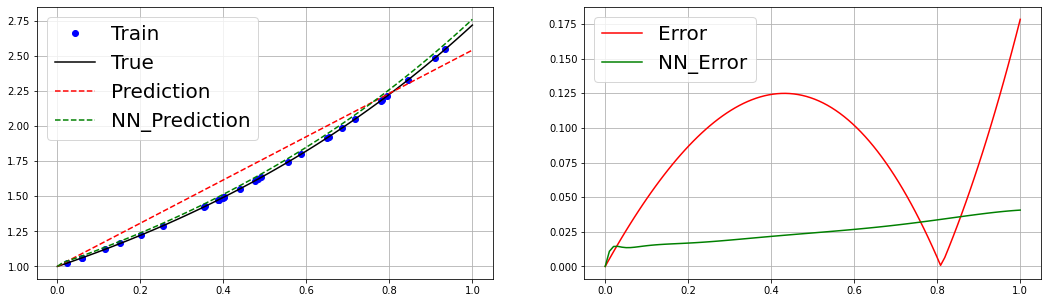

In [9]:
train_x = (np.random.rand(30)).reshape(-1, 1)
n = 1
case = 1
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 0.3476065993309021
iter : 1000, loss : 0.022807035595178604
iter : 2000, loss : 0.004965753760188818
start y + EC
iter : 0, loss : 1.038705587387085
iter : 1000, loss : 0.02006480097770691
iter : 2000, loss : 0.013172605074942112
4/4 [==============================] - 0s 2ms/step


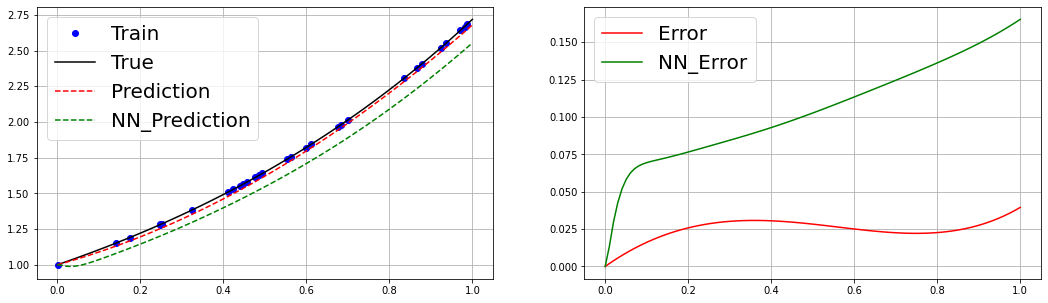

In [2]:
train_x = (np.random.rand(30)).reshape(-1, 1)
n = 2
case = 1
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 1.5079818964004517
iter : 1000, loss : 0.12086626887321472
iter : 2000, loss : 0.013754231855273247
start y + EC
iter : 0, loss : 1.0074751377105713
iter : 1000, loss : 6.176735769258812e-05
iter : 2000, loss : 3.8503785617649555e-05
4/4 [==============================] - 0s 2ms/step


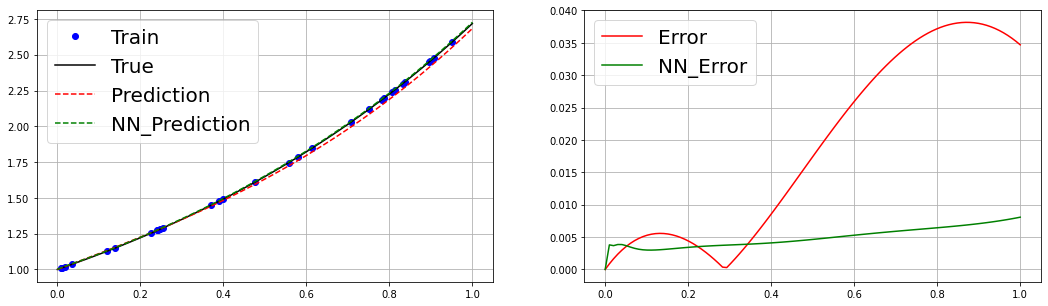

In [3]:
train_x = (np.random.rand(30)).reshape(-1, 1)
n = 3
case = 1
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 0.07292960584163666
iter : 1000, loss : 0.014081406407058239
iter : 2000, loss : 0.014081403613090515
start y + EC
iter : 0, loss : 1.154495120048523
iter : 1000, loss : 0.0002105396706610918
iter : 2000, loss : 3.6495741369435564e-05
4/4 [==============================] - 0s 3ms/step


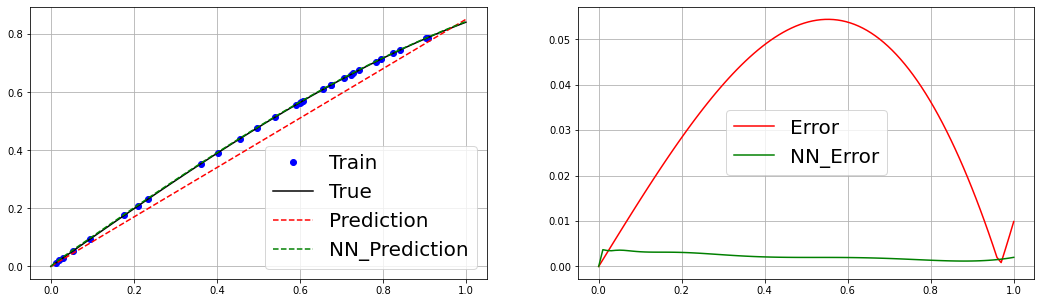

In [9]:
train_x = (np.random.rand(30)).reshape(-1, 1)
n = 1
case = 2
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 0.5863140821456909
iter : 1000, loss : 0.021814273670315742
iter : 2000, loss : 0.005356506444513798
start y + EC
iter : 0, loss : 1.8308449983596802
iter : 1000, loss : 0.0010885813971981406
iter : 2000, loss : 0.0010567337740212679
4/4 [==============================] - 0s 1ms/step


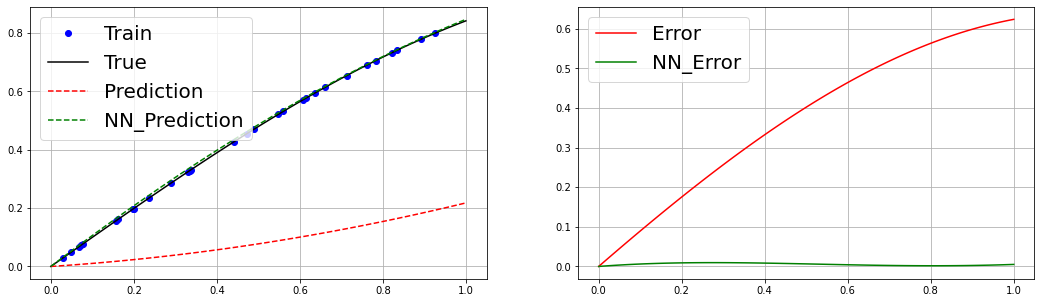

In [14]:
train_x = (np.random.rand(30)).reshape(-1, 1)
n = 2
case = 2
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 3.461300849914551
iter : 1000, loss : 0.00825831200927496
iter : 2000, loss : 0.0023827259428799152
start y + EC
iter : 0, loss : 1.0443878173828125
iter : 1000, loss : 0.0003439066931605339
iter : 2000, loss : 5.8134010032517835e-06
4/4 [==============================] - 0s 2ms/step


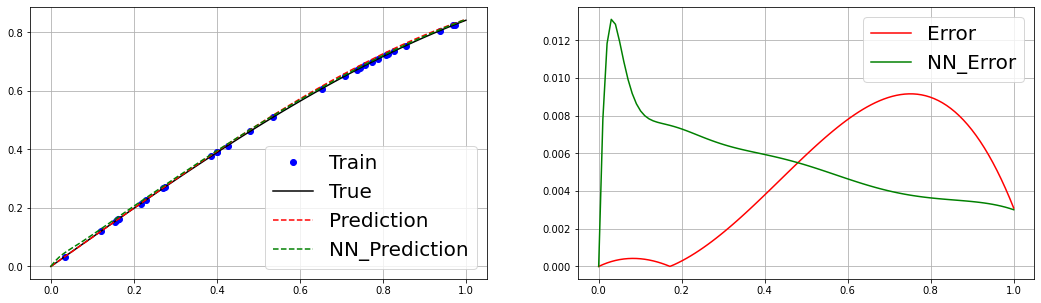

In [11]:
train_x = (np.random.rand(30)).reshape(-1, 1)
n = 3
case = 2
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 0.15789219737052917
iter : 1000, loss : 0.047088537365198135
iter : 2000, loss : 0.047088541090488434
start y + EC
iter : 0, loss : 1.0453039407730103
iter : 1000, loss : 8.471807814203203e-05
iter : 2000, loss : 1.579790659889113e-05
4/4 [==============================] - 0s 2ms/step


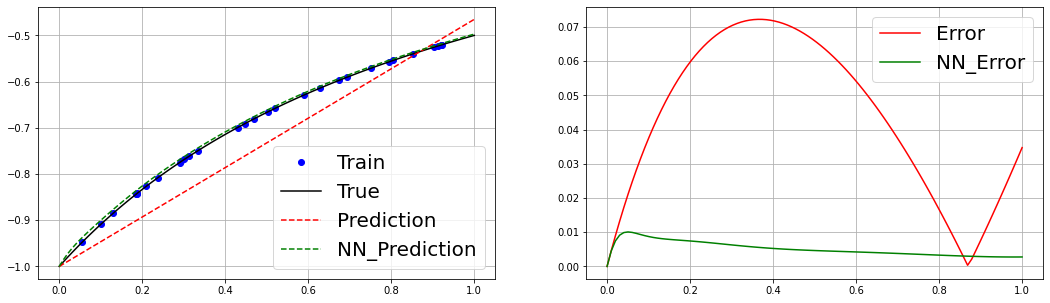

In [10]:
train_x = (np.random.rand(30)).reshape(-1, 1)
n = 1
case = 3
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 0.6511395573616028
iter : 1000, loss : 0.0891442596912384
iter : 2000, loss : 0.0139590660110116
start y + EC
iter : 0, loss : 1.003558874130249
iter : 1000, loss : 5.484951179823838e-05
iter : 2000, loss : 6.954118816793198e-06
4/4 [==============================] - 0s 2ms/step


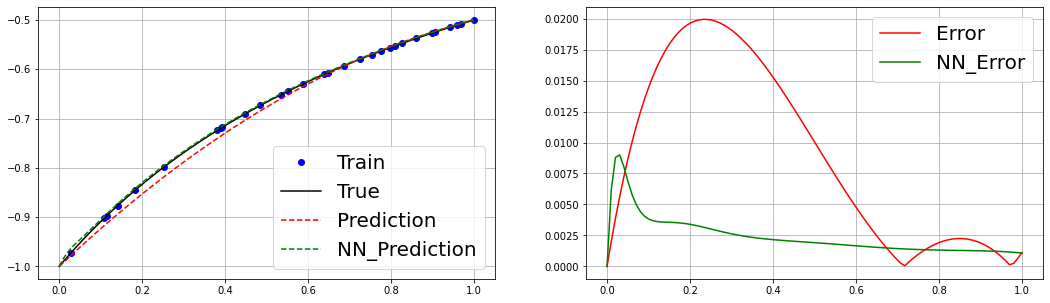

In [7]:
train_x = (np.random.rand(30)).reshape(-1, 1)
n = 2
case = 3
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 0.33139294385910034
iter : 1000, loss : 0.013964981772005558
iter : 2000, loss : 0.009153204038739204
start y + EC
iter : 0, loss : 1.0813573598861694
iter : 1000, loss : 0.004729175474494696
iter : 2000, loss : 4.749546860693954e-05
4/4 [==============================] - 0s 2ms/step


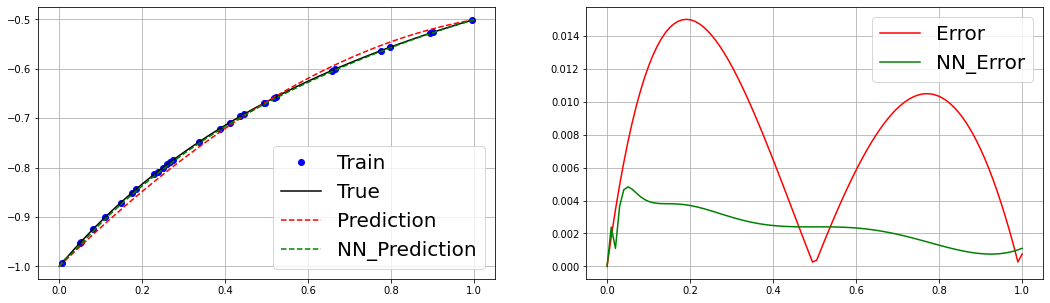

In [6]:
train_x = (np.random.rand(30)).reshape(-1, 1)
n = 3
case = 3
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

In [12]:
import math

for i in range(100):
    print((1 + tf.cos((i/100)*math.pi))/2)

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.99975324, shape=(), dtype=float32)
tf.Tensor(0.99901336, shape=(), dtype=float32)
tf.Tensor(0.997781, shape=(), dtype=float32)
tf.Tensor(0.9960574, shape=(), dtype=float32)
tf.Tensor(0.99384415, shape=(), dtype=float32)
tf.Tensor(0.9911436, shape=(), dtype=float32)
tf.Tensor(0.9879584, shape=(), dtype=float32)
tf.Tensor(0.98429155, shape=(), dtype=float32)
tf.Tensor(0.9801469, shape=(), dtype=float32)
tf.Tensor(0.97552824, shape=(), dtype=float32)
tf.Tensor(0.9704404, shape=(), dtype=float32)
tf.Tensor(0.9648882, shape=(), dtype=float32)
tf.Tensor(0.9588773, shape=(), dtype=float32)
tf.Tensor(0.95241356, shape=(), dtype=float32)
tf.Tensor(0.94550323, shape=(), dtype=float32)
tf.Tensor(0.9381533, shape=(), dtype=float32)
tf.Tensor(0.93037105, shape=(), dtype=float32)
tf.Tensor(0.92216396, shape=(), dtype=float32)
tf.Tensor(0.91354024, shape=(), dtype=float32)
tf.Tensor(0.9045085, shape=(), dtype=float32)
tf.Tensor(0.8950775, shape=(), 